In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from plotly import tools
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import gc

import matplotlib.pyplot as plt
import seaborn as sns

import os
print(os.listdir("./input"))

# from subprocess import check_output
# print(check_output(["ls", "./input"]).decode("utf8"))

['Bitcoin Historical Data.csv', 'bitstampUSD_1-min_data_2012-01-01_to_2018-03-27.csv', 'coinbaseUSD_1-min_data_2014-12-01_to_2018-01-08.csv']


In [3]:
import datetime, pytz
#define a conversion function for the native timestamps in the csv file
def dateparse (time_in_secs):    
    return pytz.utc.localize(datetime.datetime.fromtimestamp(float(time_in_secs)))


data = pd.read_csv('./input/bitstampUSD_1-min_data_2012-01-01_to_2018-03-27.csv', parse_dates=[0], date_parser=dateparse)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3273377 entries, 0 to 3273376
Data columns (total 8 columns):
 #   Column             Dtype              
---  ------             -----              
 0   Timestamp          datetime64[ns, UTC]
 1   Open               float64            
 2   High               float64            
 3   Low                float64            
 4   Close              float64            
 5   Volume_(BTC)       float64            
 6   Volume_(Currency)  float64            
 7   Weighted_Price     float64            
dtypes: datetime64[ns, UTC](1), float64(7)
memory usage: 199.8 MB


In [5]:
data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31 14:52:00+00:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,2011-12-31 14:53:00+00:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2,2011-12-31 14:54:00+00:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
3,2011-12-31 14:55:00+00:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
4,2011-12-31 14:56:00+00:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39


In [6]:
# First thing is to fix the data for bars/candles where there are no trades. 
# Volume/trades are a single event so fill na's with zeroes for relevant fields...
data['Volume_(BTC)'].fillna(value=0, inplace=True)
data['Volume_(Currency)'].fillna(value=0, inplace=True)
data['Weighted_Price'].fillna(value=0, inplace=True)

# next we need to fix the OHLC (open high low close) data which is a continuous timeseries so
# lets fill forwards those values...
data['Open'].fillna(method='ffill', inplace=True)
data['High'].fillna(method='ffill', inplace=True)
data['Low'].fillna(method='ffill', inplace=True)
data['Close'].fillna(method='ffill', inplace=True)

data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31 14:52:00+00:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,2011-12-31 14:53:00+00:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2,2011-12-31 14:54:00+00:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
3,2011-12-31 14:55:00+00:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
4,2011-12-31 14:56:00+00:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39


In [7]:
# create valid date range
start = datetime.datetime(2015, 1, 1, 0, 0, 0, 0, pytz.UTC)
end = datetime.datetime(2018, 11, 11, 0, 0, 0, 0, pytz.UTC)

# find rows between start and end time and find the first row (00:00 monday morning)
weekly_rows = data[(data['Timestamp'] >= start) & (data['Timestamp'] <= end)].groupby([pd.Grouper(key='Timestamp', freq='W-MON')]).first().reset_index()
weekly_rows.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2015-01-05 00:00:00+00:00,317.66,317.67,317.66,317.67,0.500000,158.831853,317.663706
1,2015-01-12 00:00:00+00:00,272.45,305.00,272.45,291.10,175.837078,50502.066285,287.209426
2,2015-01-19 00:00:00+00:00,271.49,271.49,270.79,271.33,42.757775,11587.881189,271.012261
3,2015-01-26 00:00:00+00:00,212.21,212.21,212.21,212.21,10.000000,2122.100000,212.210000
4,2015-02-02 00:00:00+00:00,271.75,271.75,270.11,270.11,55.007325,14887.524494,270.646217


In [8]:
# We use Plotly to create the plots https://plot.ly/python/
trace1 = go.Scatter(
    x = weekly_rows['Timestamp'],
    y = weekly_rows['Open'].astype(float),
    mode = 'lines',
    name = 'Open'
)

trace2 = go.Scatter(
    x = weekly_rows['Timestamp'],
    y = weekly_rows['Close'].astype(float),
    mode = 'lines',
    name = 'Close'
)
trace3 = go.Scatter(
    x = weekly_rows['Timestamp'],
    y = weekly_rows['Weighted_Price'].astype(float),
    mode = 'lines',
    name = 'Weighted Avg'
)

layout = dict(
    title='Historical Bitcoin Prices (2015-2018) with the Slider ',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                #change the count to desired amount of months.
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

data = [trace1,trace2, trace3]
fig = dict(data=data, layout=layout)
iplot(fig, filename = "Time Series with Rangeslider")

In [9]:
trace1 = go.Scatter(
    x = weekly_rows['Timestamp'],
    y = weekly_rows['Volume_(Currency)'].astype(float),
    mode = 'lines',
    name = 'Bitcoin Price (Open)'
)

layout = dict(
    title='Historical Bitcoin Volume (USD) (2015-2018) with the slider',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

data = [trace1]
fig = dict(data=data, layout=layout)
iplot(fig, filename = "Time Series with Rangeslider")

In [10]:
#BTC Volume vs USD visualization
trace = go.Scattergl(
    y = weekly_rows['Volume_(BTC)'].astype(float),
    x = weekly_rows['Weighted_Price'].astype(float),
    mode = 'markers',
    marker = dict(
        color = '#FFBAD2',
        line = dict(width = 1)
    )
)
layout = go.Layout(
    title='BTC Volume v/s USD',
 xaxis=dict(
        title=dict(
            text='Weighted Price',
            font=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        )
    ),
    yaxis=dict(  # ✅ Định nghĩa đúng cho trục Y
        title=dict(
            text='Volume BTC',
            font=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        )
    ))
data = [trace]
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='compare_webgl')

In [29]:
#load the dataset 
data = pd.read_csv('./input/coinbaseUSD_1-min_data_2014-12-01_to_2018-01-08.csv',parse_dates=[0], date_parser=dateparse) 
data['Timestamp'] = data['Timestamp'].dt.tz_localize(None)
data = data.groupby([pd.Grouper(key='Timestamp', freq='H')]).first().reset_index()
data = data.set_index('Timestamp')
data = data[['Weighted_Price']]
data['Weighted_Price'].fillna(method='ffill', inplace=True)

In [30]:
data.shape

(27212, 1)

In [31]:
# split data
split_date = '25-Jun-2017'
data_train = data.loc[data.index <= split_date].copy()
data_test = data.loc[data.index > split_date].copy()

In [32]:
# Data preprocess
training_set = data_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))

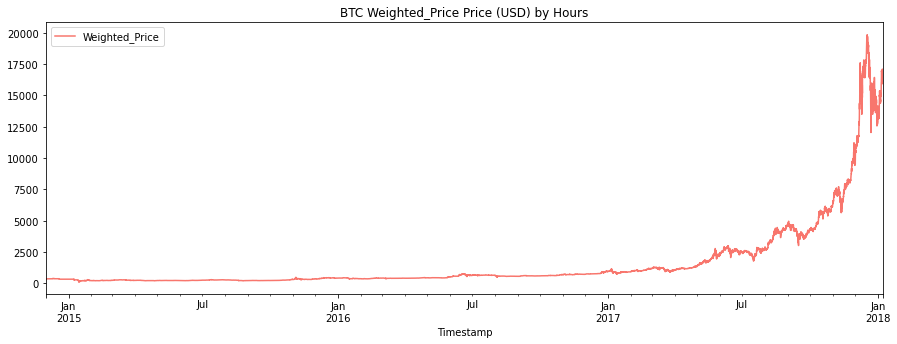

In [33]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = data.plot(style='', figsize=(15,5), color=color_pal[0], title='BTC Weighted_Price Price (USD) by Hours')

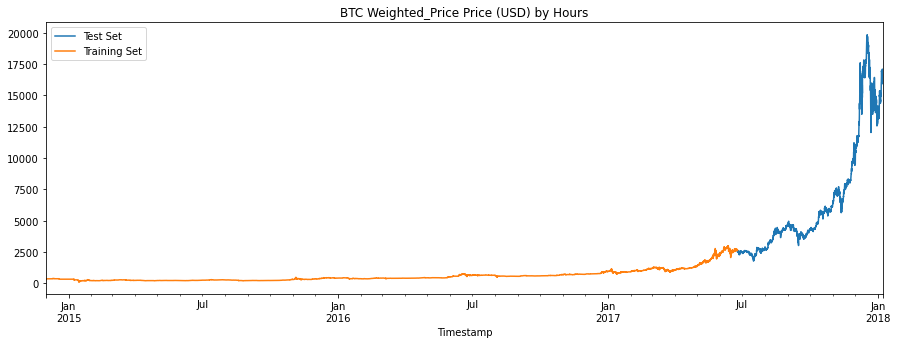

In [34]:
_ = data_test \
    .rename(columns={'Weighted_Price': 'Test Set'}) \
    .join(data_train.rename(columns={'Weighted_Price': 'Training Set'}), how='outer') \
    .plot(figsize=(15,5), title='BTC Weighted_Price Price (USD) by Hours', style='')

In [35]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation


model = Sequential()
model.add(LSTM(128,activation="sigmoid",input_shape=(1,1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=50, verbose=2)

Epoch 1/100
450/450 - 2s - loss: 0.0413 - 2s/epoch - 4ms/step
Epoch 2/100
450/450 - 1s - loss: 0.0173 - 998ms/epoch - 2ms/step
Epoch 3/100
450/450 - 1s - loss: 0.0097 - 981ms/epoch - 2ms/step
Epoch 4/100
450/450 - 1s - loss: 0.0067 - 947ms/epoch - 2ms/step
Epoch 5/100
450/450 - 1s - loss: 0.0051 - 975ms/epoch - 2ms/step
Epoch 6/100
450/450 - 1s - loss: 0.0041 - 934ms/epoch - 2ms/step
Epoch 7/100
450/450 - 1s - loss: 0.0034 - 947ms/epoch - 2ms/step
Epoch 8/100
450/450 - 1s - loss: 0.0029 - 938ms/epoch - 2ms/step
Epoch 9/100
450/450 - 1s - loss: 0.0026 - 935ms/epoch - 2ms/step
Epoch 10/100
450/450 - 1s - loss: 0.0023 - 936ms/epoch - 2ms/step
Epoch 11/100
450/450 - 1s - loss: 0.0020 - 932ms/epoch - 2ms/step
Epoch 12/100
450/450 - 1s - loss: 0.0018 - 942ms/epoch - 2ms/step
Epoch 13/100
450/450 - 1s - loss: 0.0016 - 945ms/epoch - 2ms/step
Epoch 14/100
450/450 - 1s - loss: 0.0015 - 941ms/epoch - 2ms/step
Epoch 15/100
450/450 - 1s - loss: 0.0013 - 922ms/epoch - 2ms/step
Epoch 16/100
450/450 -

In [36]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 66689 (260.50 KB)
Trainable params: 66689 (260.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
# Making the predictions
test_set = data_test.values
inputs = np.reshape(test_set, (len(test_set), 1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
predicted_BTC_price = model.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)

148/148 [==============================] - 0s 1ms/step


In [40]:
data_test['Weighted_Price_Prediction'] = predicted_BTC_price
data_all = pd.concat([data_test, data_train], sort=False)

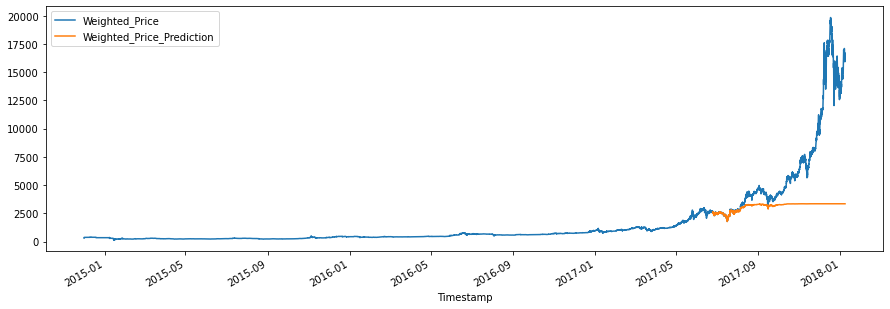

In [42]:
_ = data_all[['Weighted_Price','Weighted_Price_Prediction']].plot(figsize=(15, 5))

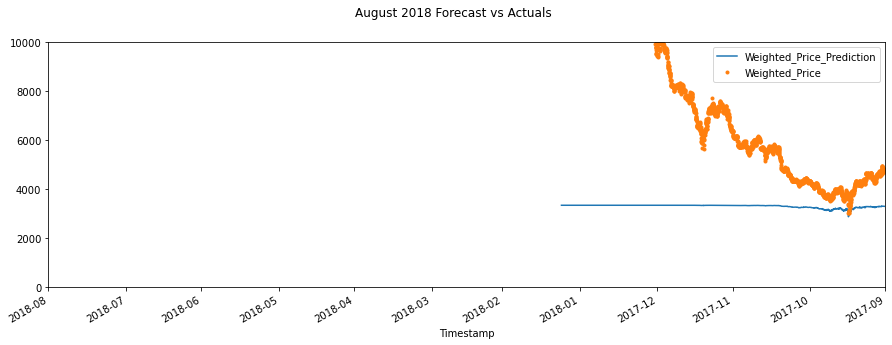

In [44]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['Weighted_Price_Prediction','Weighted_Price']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='08-01-2018', upper='09-01-2017')
ax.set_ylim(0, 10000)
plot = plt.suptitle('August 2018 Forecast vs Actuals')

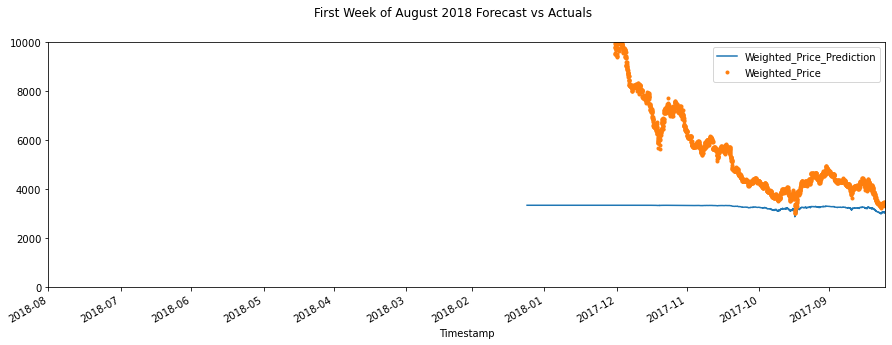

In [45]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['Weighted_Price_Prediction','Weighted_Price']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='08-01-2018', upper='08-08-2017')
ax.set_ylim(0, 10000)
plot = plt.suptitle('First Week of August 2018 Forecast vs Actuals')

In [46]:
#calculate MSE and MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_squared_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test['Weighted_Price_Prediction'])

31797222.138092596

In [47]:
mean_absolute_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test['Weighted_Price_Prediction'])

3504.3289545693056

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [57]:
data = pd.read_csv('./input/coinbaseUSD_1-min_data_2014-12-01_to_2018-01-08.csv',parse_dates=[0], date_parser=dateparse) 
data['Timestamp'] = data['Timestamp'].dt.tz_localize(None)
data = data.groupby([pd.Grouper(key='Timestamp', freq='H')]).first().reset_index()
data = data.set_index('Timestamp')
data = data[['Weighted_Price']]
data['Weighted_Price'].fillna(method='ffill', inplace=True)

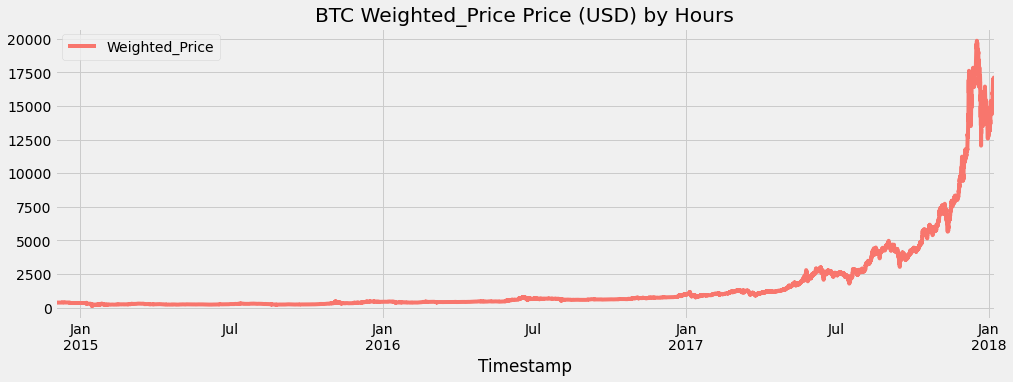

In [58]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = data.plot(style='', figsize=(15,5), color=color_pal[0], title='BTC Weighted_Price Price (USD) by Hours')

In [61]:
split_date = '25-Jun-2017'
data_train = data.loc[data.index <= split_date].copy()
data_test = data.loc[data.index > split_date].copy()

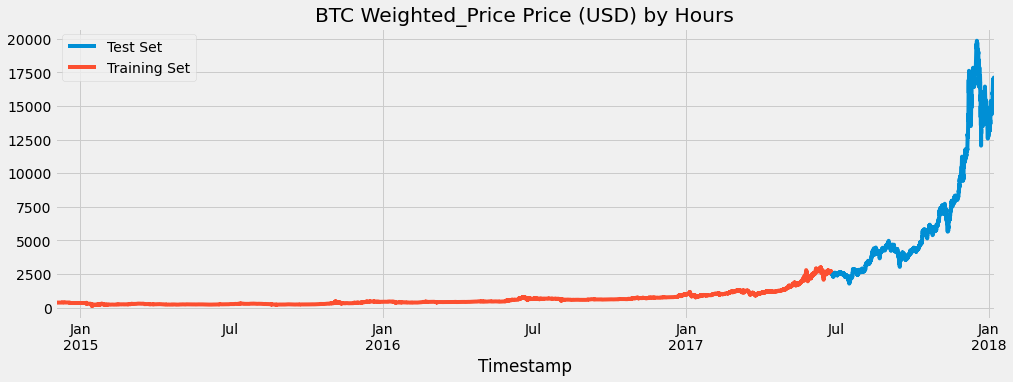

In [62]:
_ = data_test \
    .rename(columns={'Weighted_Price': 'Test Set'}) \
    .join(data_train.rename(columns={'Weighted_Price': 'Training Set'}), how='outer') \
    .plot(figsize=(15,5), title='BTC Weighted_Price Price (USD) by Hours', style='')

In [65]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [66]:
X_train, y_train = create_features(data_train, label='Weighted_Price')
X_test, y_test = create_features(data_test, label='Weighted_Price')

In [68]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
model =  xgb.XGBRegressor(objective ='reg:linear',min_child_weight=10, booster='gbtree', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=False) # Change verbose to True if you want to see it train

TypeError: fit() got an unexpected keyword argument 'early_stopping_rounds'